In [226]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

pic = Image.open('puzzle.png')
pic_arr = np.array(pic)

## Parameters

In [234]:
population_size = 100
generations_size = 10
initial_generation_limit = 15

#Figures
color_transparency = 200
## Circle
min_radius = 2
max_radius = 10
## Polygons
min_edge_length = 30
max_edge_length = 100

# Mutation
mutation_chance = 0.4
min_mutation_amount = 1
max_mutation_amount = 10

#Crossover
min_crossover_amount = 10
max_crossover_amount = 100

#Selection
selection_percent = 0.1

## Working with images

In [228]:
def draw_circles(picture, data):
    draw = ImageDraw.Draw(picture, 'RGBA')
    for [(x, y), radius, color] in data:
        draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=color)

## Figure classes

In [256]:
class Circle:
    def __init__(self, center, radius, color):
        x, y = center
        self.points = [x - radius, y - radius, 
                      x + radius, y + radius]
        self.color = color
    
    def draw(self, picture):
        draw = ImageDraw.Draw(picture, 'RGBA')
        draw.ellipse(self.points, fill=self.color)
    
    @staticmethod 
    def get_random():
        radius = np.random.uniform(low=min_radius, high=max_radius)

        x = np.random.uniform(0, pic.size[0])
        y = np.random.uniform(0, pic.size[1])
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256), color_transparency)
        
        return Circle((x, y), radius, color)
    
class Polygon:
    def __init__(self, points, color):
        self.points = points
        self.color = color
    
    def draw(self, picture):
        draw = ImageDraw.Draw(picture, 'RGBA')
        draw.polygon(self.points, fill=self.color)
                     
    @staticmethod
    def get_random(n_vertices=3):
        points = []
        curr_point = (np.random.randint(0, pic.size[0]), np.random.randint(0, pic.size[0]))
        points.append(curr_point)
        for _ in range(n_vertices - 1):
#             new_point = (np.random.uniform(curr_point[0] + min_edge_length, curr_point[0] + max_edge_length), 
#                          np.random.uniform(curr_point[1] + min_edge_length, curr_point[1] + max_edge_length))
            new_point = (np.random.uniform(0, pic.size[0]), np.random.uniform(0, pic.size[1]))
            curr_point = new_point
            points.append(curr_point)
        
        color = (np.random.randint(256), np.random.randint(256), 
                 np.random.randint(256), color_transparency)
        return Polygon(points, color)
        

## Chromosome class 

In [274]:
class Chromosome:
    def __init__(self, gene):
        self.picture = Image.fromarray(gene)
        self.update_score()

    def mutate(self):
        choice = np.random.rand()
        if choice >= mutation_chance:
            return

        min_mutation = int(min_mutation_amount*self.score)
        max_mutation = int(max_mutation_amount*self.score)
        mutation_amount = np.random.randint(min_mutation, max_mutation)
        to_draw = []

        for _ in range(mutation_amount):
            figure_choice = np.random.randint(2)
            
#           Temp
            figure_choice = 0
            if figure_choice == 0:
                polygon = Polygon.get_random()
                to_draw.append(polygon)
            else:
                to_draw.append(Circle.get_random())
        start = timer()
        for figure in to_draw:
            figure.draw(self.picture)
        end = timer()
        print('Draw time:', str(end - start))
        
        self.update_score()
 
    def update_score(self, original=pic):
        self.score = fitness_score(self.picture, original)

    @staticmethod
    def get_random():
        random_data = Chromosome.random_gene()
        return Chromosome(random_data)

    @staticmethod
    def random_gene():
        #         return np.random.randint(0, 256, pic_arr.shape)
        return np.zeros_like(pic_arr)

    def __eq__(self, other):
        return self.score == other.score

    def __lt__(self, other):
        return self.score < other.score

    def __repr__(self):
        self.picture.show()
        return str(self.score)


## Utilities for the genetic algorithm

In [230]:
def fitness_score(current, original=pic):
#     curr_grey = current.convert("L")
#     orig_grey = original.convert("L")
#     res = np.subtract(curr_grey, orig_grey)
    res = np.subtract(current, original)
    res = np.square(res)
    return np.sum(res)/(current.size[0]*current.size[1])   
    

def cross2(pic1, pic2):
    mean = np.mean([np.array(pic1), np.array(pic2)], axis=(0))
    return Chromosome(np.array(mean, dtype=np.uint8))

def cross_n(pictures):
    genes = np.array([np.array(picture) for picture in pictures])
    result = np.array(np.mean(genes, axis=(0)), dtype=np.uint8)
    return Chromosome(result)

    
def crossover(generation):
#     indexes = list(range(0, len(generation)))
#     if len(generation) > n:
#         to_cross = np.random.choice(indexes, n, replace=False)
#     else:
#         to_cross = indexes
    
#     res = []
#     for i in range(1, len(to_cross)):
#         child = cross_2(generation[i - 1], generation[i])
#         res.append(child)
    
#     return res
    crossover_amount = min(np.random.randint(min_crossover_amount, max_crossover_amount + 1), len(generation))
    to_cross = generation[: crossover_amount]
    result = []
    for i in range(1, len(to_cross)):
        curr_result = cross2(to_cross[i - 1].picture, to_cross[i].picture)
        result.append(curr_result)
    return result
    

def mutation(generation):
    for sample in generation:
        sample.mutate()

        
def selection(generation):
    n_remove = int(selection_percent*len(generation))
    return generation[: len(generation) - n_remove]



In [275]:
from timeit import default_timer as timer

generation = [Chromosome.get_random() for _ in range(initial_generation_limit)]

for i in range(generations_size):
    cycle_start = timer()
    print("\n-------------------------")
    start = timer()
    children = crossover(generation)
    end = timer()
    print("Crossover time:", str(end - start))
    
    start = timer()
    generation += children 
    end = timer()
    print("Merge time:", str(end - start))

    
    start = timer()
    mutation(generation)
    end = timer()
    print("Mutation time:", str(end - start))

    start = timer()
    generation.sort()
    end = timer()
    print("Sort time:", str(end - start))

    start = timer()
    generation = selection(generation)
    end = timer()
    print("Selection time:", str(end - start))
    
#     while len(generation) > population_size:
#         generation.pop()
#     if i > generations_size - 10:
#         print(generation[0])
        
    cycle_end = timer()
    print("Cycle took:", str(cycle_end - cycle_start))
    
print(generation[0])
for i in range(len(generation)):
    generation[i].picture.save('last_cycle/img{}.png'.format(str(i)))
    
generation[0].picture.save('result.png')


-------------------------
Crossover time: 0.3180528499997308
Merge time: 3.4709992178250104e-06
Draw time: 0.020473636999668088
Draw time: 0.02599719099998765
Draw time: 0.08377711400135013
Draw time: 0.03756702700047754
Draw time: 0.03277881800022442
Draw time: 0.021812009001223487
Draw time: 0.07956490899960045
Draw time: 0.04140863800057559
Draw time: 0.06355821899887815
Draw time: 0.04650519200004055
Draw time: 0.0807128720007313
Mutation time: 0.8366575119998743
Sort time: 5.877900002815295e-05
Selection time: 1.0294999810867012e-05
Cycle took: 1.1557159740004863

-------------------------
Crossover time: 0.5390895950004051
Merge time: 3.772000127355568e-06
Draw time: 0.01857322599971667
Draw time: 0.009549902999424376
Draw time: 0.026389722001113114
Draw time: 0.053127998999116244
Draw time: 0.08465715800048201
Draw time: 0.026057831000798615
Draw time: 0.04415276600047946
Draw time: 0.2877068429988867
Draw time: 0.09988947900092171
Draw time: 0.2688806679998379
Draw time: 0.035

Draw time: 0.3436498130013206
Draw time: 0.21465279499898315
Draw time: 0.06934902499961026
Draw time: 0.030719691998456256
Draw time: 0.07801777699933155
Draw time: 0.03668278399891278
Draw time: 0.02775334199941426
Draw time: 0.046902366000722395
Draw time: 0.019436639000559808
Draw time: 0.05643505799889681
Draw time: 0.04878618200018536
Draw time: 0.030951482000091346
Draw time: 0.04371129300125176
Draw time: 0.18464300500090758
Draw time: 0.2333047699994495
Draw time: 0.23359886000071128
Draw time: 0.30580360499880044
Draw time: 0.13456909299929976
Draw time: 0.16033790599976783
Draw time: 0.18537124900103663
Draw time: 0.3587780340003519
Mutation time: 16.83625252099955
Sort time: 0.0009408200003235834
Selection time: 0.00018992200057255104
Cycle took: 17.72895523599982

-------------------------
Crossover time: 0.7481558529998438
Merge time: 8.040000466280617e-06
Draw time: 0.031982706001144834
Draw time: 0.06875264000154857
Draw time: 0.05023001900008239
Draw time: 0.0170400569

Draw time: 0.2141173540003365
Draw time: 0.05580751400157169
Draw time: 0.345440814999165
Draw time: 0.281177053000647
Draw time: 0.20325557800060778
Draw time: 0.2589017509999394
Draw time: 0.24167777000002388
Draw time: 0.28611101400019834
Draw time: 0.26416942099967855
Draw time: 0.1655406909994781
Draw time: 0.10099531000014395
Draw time: 0.15285784199841146
Draw time: 0.11116668300019228
Draw time: 0.0360386770007608
Draw time: 0.288668568000503
Draw time: 0.12187613200148917
Draw time: 0.11158842100121547
Draw time: 0.3181834440001694
Draw time: 0.32095545700030925
Draw time: 0.28209157300079823
Draw time: 0.0700749329989776
Draw time: 0.03384725599971716
Draw time: 0.08069277399954444
Draw time: 0.010342878000301425
Draw time: 0.014663308000308461
Draw time: 0.010429329000544385
Draw time: 0.01941568999973242
Draw time: 0.07541567500084057
Draw time: 0.06429900199873373
Draw time: 0.05320169900005567
Draw time: 0.024760567999692285
Draw time: 0.024080795999907423
Draw time: 0.07

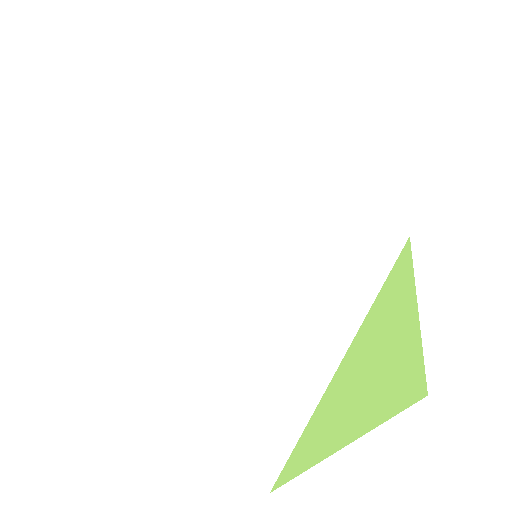

In [272]:
# generation = [Chromosome.get_random() for _ in range(initial_generation_limit)]
# generation[0].score
generation = [Chromosome.get_random() for _ in range(initial_generation_limit)]
test = generation[0].picture
draw = ImageDraw.Draw(pic, 'RGBA')
polygon = Polygon.get_random(3)
polygon.draw(test)
test

In [223]:
generation = [Chromosome.get_random() for _ in range(initial_generation_limit)]
a = generation[0].gene
b = generation[1].gene
d = np.mean([a, b], axis=(0))
d.shape

AttributeError: 'Chromosome' object has no attribute 'gene'